In [2]:
import pandas as pd
import numpy as np

In [4]:
from ipynb.fs.full.exploration_cleaning import get_data, get_paths
data = get_data()

### Difference between weekday and weekend.

In [6]:
# Turn strings in to pandas date.
data['Date'] = pd.to_datetime(data['Date'], yearfirst = True)
# Get the day of the week for each date.
data['dayofweek'] = data['Date'].dt.dayofweek
data.head()

/var/folders/sp/pv6m55cn0cnf_540z_5jtfgr0000gn/T/ipykernel_2178/3191454190.py:2: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'], yearfirst = True)


,Station or stop,Date,Number of train rides,Minutes of delay,Name,Country,Coordinate Latitude,Coordinate Longitude,dayofweek
0,80197079,2016-03-16,39,49,KINDSBACH,DEUTSCHLAND,49.420450,7.613668,2
1,80160168,2016-11-01,12,0,NIEDERTREBRA,DEUTSCHLAND,51.065500,11.580700,1
2,80105122,2016-04-30,16,2,HAMM FELDMARK,DEUTSCHLAND,51.697611,7.787870,5
3,80190793,2016-07-31,14,0,LUDWIGSHAFEN (RHEIN) BASF,DEUTSCHLAND,49.510682,8.428922,6
4,80231464,2016-05-04,10,2,BURGKEMNITZ,DEUTSCHLAND,51.689400,12.407990,2


In [7]:
data_weekday = data.loc[data['dayofweek'].isin([0, 1, 2, 3, 4])]
data_weekend = data.loc[data['dayofweek'].isin([5, 6])]

<Axes: >

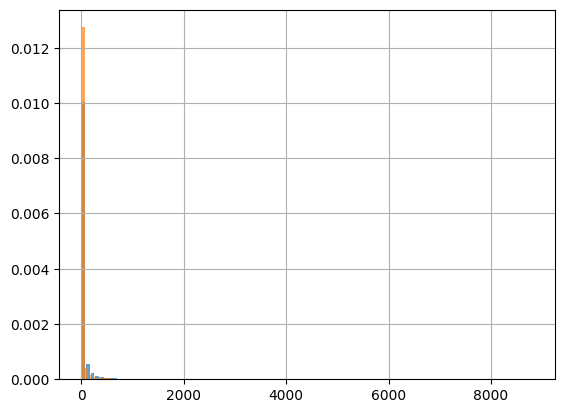

In [8]:
data_weekday["Minutes of delay"].hist(bins = 100, rwidth = 0.8, density = True, alpha = .7)
data_weekend["Minutes of delay"].hist(bins = 100, rwidth = 0.8, density = True, alpha = .7)

In [9]:
data_weekday

,Station or stop,Date,Number of train rides,Minutes of delay,Name,Country,Coordinate Latitude,Coordinate Longitude,dayofweek
0,80197079,2016-03-16,39,49,KINDSBACH,DEUTSCHLAND,49.420450,7.613668,2
1,80160168,2016-11-01,12,0,NIEDERTREBRA,DEUTSCHLAND,51.065500,11.580700,1
4,80231464,2016-05-04,10,2,BURGKEMNITZ,DEUTSCHLAND,51.689400,12.407990,2
5,80020644,2016-10-04,34,0,HERBERTSHOFEN,DEUTSCHLAND,48.529570,10.849300,1
6,80042267,2016-04-15,43,116,HOSENA,DEUTSCHLAND,51.454332,14.017600,4
...,...,...,...,...,...,...,...,...,...
766023,80136234,2016-10-26,82,0,UELZEN,DEUTSCHLAND,52.964129,10.546461,2
766024,80100388,2016-01-29,33,2,HERNE,DEUTSCHLAND,51.542128,7.211104,4
766025,80143321,2016-05-30,40,0,KOLLMARSREUTE,DEUTSCHLAND,48.099070,7.887097,0
766026,80174508,2016-07-05,14,0,NEUKIRCHEN (B SULZBACH-ROSENBERG),DEUTSCHLAND,49.525068,11.620659,1


In [10]:
# Calculate mean for every station by weekday or weekend
data_weekday_mean = data_weekday.groupby('Station or stop')['Minutes of delay'].mean()
data_weekend_mean = data_weekend.groupby('Station or stop')['Minutes of delay'].mean()
data_by_weekday_weekend = pd.merge(data_weekday_mean, data_weekend_mean, how = "left", on = "Station or stop", suffixes = ("_weekday", "_weekend"))

### Make visualisations for each path

In [11]:
from tueplots import bundles
from tueplots.constants.color import rgb
from matplotlib import ticker
import matplotlib.pyplot as plt

# set plotting stylesheet
plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))

In [12]:
paths = np.load('../dat/paths.npy', allow_pickle='TRUE').item()

In [13]:
unique_stations = {}
for key, value in paths.items():
    stations_key = tuple(value['stations'])
    if stations_key not in unique_stations:
        unique_stations[stations_key] = value

# If you want to convert it back to a dictionary
unique_stations_dict = {f'path{i}': value for i, (key, value) in enumerate(unique_stations.items())}

In [14]:
paths_sorted = sorted(unique_stations_dict.items(), key = lambda x: x[1]["mean_delay"])

In [15]:
for k, v in dict(paths_sorted).items():
    if v["routes"] == [4801, 4812, 4080, 4004, 4010]:
        print(v["mean_delay"])

In [16]:
# get names for the sorted path list to use in plots
names_paths = []

for path in paths_sorted:
    names_paths.append(path[0].capitalize())

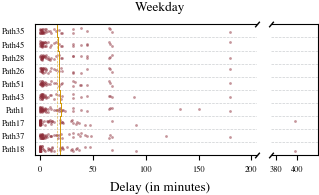

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw={'width_ratios': [210, 45]})
fig.suptitle("Weekday")

for i in np.arange(10):
    u_wd = np.random.rand(data_weekday_mean[data_weekday_mean.index.isin(paths_sorted[i][1]["stations"])].shape[0])
    wd = data_weekday_mean[data_weekday_mean.index.isin(paths_sorted[i][1]["stations"])]
    ax1.plot(wd, .8 + 0.4 * u_wd + 9 - i, "o", color=rgb.tue_red, alpha=0.5, mec = "none", ms = 2)
    ax1.axvline(x=data_weekday_mean[data_weekday_mean.index.isin(paths_sorted[i][1]["stations"])].mean(), 
               ymin= (9 - i) * 0.1, ymax = (10 - i) * 0.1, color=rgb.tue_orange, linewidth = 0.7)
    # ax.axvline(x=data_weekday_mean[data_weekday_mean.index.isin(paths_sorted[i][1]["stations"])].median(), 
    #            ymin= (9 - i) * 0.1, ymax = (10 - i) * 0.1, color=rgb.tue_gray, linewidth = 0.5)
    ax1.axhline(i + 0.5, color = rgb.tue_dark, alpha = 0.25, ls = "--", linewidth = 0.5)

    ax2.plot(wd, .8 + 0.4 * u_wd + 9 - i, "o", color=rgb.tue_red, alpha=0.5, mec = "none", ms = 2)
    # ax.axvline(x=data_weekday_mean[data_weekday_mean.index.isin(paths_sorted[i][1]["stations"])].median(), 
    #            ymin= (9 - i) * 0.1, ymax = (10 - i) * 0.1, color=rgb.tue_gray, linewidth = 0.5)
    ax2.axhline(i + 0.5, color = rgb.tue_dark, alpha = 0.25, ls = "--", linewidth = 0.5)


ax1.axvline(x=data_weekday_mean[data_weekday_mean.index.isin(paths_sorted[0][1]["stations"])].mean(),
           color=rgb.tue_orange, linewidth = 0.5, ls = "--", alpha = .7)

ax2.axvline(x=data_weekday_mean[data_weekday_mean.index.isin(paths_sorted[0][1]["stations"])].mean(),
           color=rgb.tue_orange, linewidth = 0.5, ls = "--", alpha = .7, label = "Mean \nPath35")
ax2.axvline(x=data_weekday_mean[data_weekday_mean.index.isin(paths_sorted[0][1]["stations"])].mean(), 
            ymin= (9 - i) * 0.1, ymax = (10 - i) * 0.1, color=rgb.tue_orange, linewidth = 0.5, label = "Mean \n/ path")

ax1.set_ylim(0.5, 10.5)
ax1.set_yticks(range(1, 11, 1), names_paths[:10][::-1])

ax1.set_xlim(-5, 205)
ax2.set_xlim(375, 420)
ax2.set_xticks([380, 400])

fig.supxlabel('Delay (in minutes)')

ax1.tick_params(axis='both', which='both',
               bottom=True, top=False, labelbottom=True,
               left=False, right=False, labelleft=True)
ax2.tick_params(axis='both', which='both',
               bottom=True, top=False, labelbottom=True,
               left=False, right=False, labelleft=False)

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

d = 1.2  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=4,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [1, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

#ax2.legend(loc = "upper right")

fig.savefig("../doc/fig/plot_FP_01_Weekday.pdf")

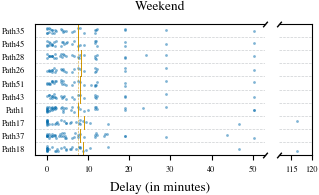

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw={'width_ratios': [56, 8]})
fig.suptitle("Weekend")
fig.supxlabel("Delay (in minutes)")

for i in np.arange(10):
    u_wd = np.random.rand(data_weekend_mean[data_weekend_mean.index.isin(paths_sorted[i][1]["stations"])].shape[0])
    wd = data_weekend_mean[data_weekend_mean.index.isin(paths_sorted[i][1]["stations"])]
    ax1.plot(wd, .8 + 0.4 * u_wd + 9 - i, "o", color=rgb.tue_blue, alpha=0.5, mec = "none", ms = 2)
    ax1.axvline(x=data_weekend_mean[data_weekend_mean.index.isin(paths_sorted[i][1]["stations"])].mean(), 
               ymin= (9 - i) * 0.1, ymax = (10 - i) * 0.1, color=rgb.tue_orange, linewidth = 0.7)
    # ax.axvline(x=data_weekend_mean[data_weekend_mean.index.isin(paths_sorted[i][1]["stations"])].median(), 
    #            ymin= (9 - i) * 0.1, ymax = (10 - i) * 0.1, color=rgb.tue_gray, linewidth = 0.5)
    ax1.axhline(i + 0.5, color = rgb.tue_dark, alpha = 0.25, ls = "--", linewidth = 0.5)

    ax2.plot(wd, .8 + 0.4 * u_wd + 9 - i, "o", color=rgb.tue_blue, alpha=0.5, mec = "none", ms = 2)
    ax2.axvline(x=data_weekend_mean[data_weekend_mean.index.isin(paths_sorted[i][1]["stations"])].mean(), 
               ymin= (9 - i) * 0.1, ymax = (10 - i) * 0.1, color=rgb.tue_orange, linewidth = 0.5)
    # ax.axvline(x=data_weekend_mean[data_weekend_mean.index.isin(paths_sorted[i][1]["stations"])].median(), 
    #            ymin= (9 - i) * 0.1, ymax = (10 - i) * 0.1, color=rgb.tue_gray, linewidth = 0.5)
    ax2.axhline(i + 0.5, color = rgb.tue_dark, alpha = 0.25, ls = "--", linewidth = 0.5)

ax1.axvline(x=data_weekend_mean[data_weekend_mean.index.isin(paths_sorted[0][1]["stations"])].mean(),
           color=rgb.tue_orange, linewidth = 0.5, ls = "--", alpha = .7)

ax2.axvline(x=data_weekend_mean[data_weekend_mean.index.isin(paths_sorted[0][1]["stations"])].mean(),
           color=rgb.tue_orange, linewidth = 0.5, ls = "--", alpha = .7, label = "Mean \nPath35")
ax2.axvline(x=data_weekend_mean[data_weekend_mean.index.isin(paths_sorted[0][1]["stations"])].mean(), 
            ymin= (9 - i) * 0.1, ymax = (10 - i) * 0.1, color=rgb.tue_orange, linewidth = 0.5, label = "Mean \n/ path")

ax1.set_ylim(0.5, 10.5)
ax1.set_yticks(range(1, 11, 1), names_paths[:10][::-1])

ax1.set_xlim(-3, 53)
ax2.set_xlim(112, 120)
ax2.set_xticks([115, 120])

ax1.tick_params(axis='both', which='both',
               bottom=True, top=False, labelbottom=True,
               left=False, right=False, labelleft=True)
ax2.tick_params(axis='both', which='both',
               bottom=True, top=False, labelbottom=True,
               left=False, right=False, labelleft=False)

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

d = 1.2  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=4,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [1, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

#ax2.legend(loc = "upper right")

fig.savefig("../doc/fig/plot_FP_02_Weekend.pdf")

In [19]:
paths_sorted[0][1]["mean_delay"]
len(paths_sorted)

54

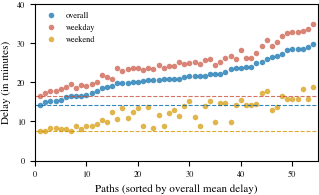

In [21]:
fig, ax = plt.subplots()

for i in np.arange(len(paths_sorted)):
    wd = data_weekday_mean[data_weekday_mean.index.isin(paths_sorted[i][1]["stations"])].mean()
    we = data_weekend_mean[data_weekend_mean.index.isin(paths_sorted[i][1]["stations"])].mean()
    ax.plot(i + 1, paths_sorted[i][1]["mean_delay"], "o", color = rgb.tue_blue, alpha = 0.7, mec = "none", ms = 4, label = "overall")
    ax.plot(i + 1, wd, "o", color = rgb.tue_ocre, alpha = 0.7, mec = "none", ms = 4, label = "weekday")
    ax.plot(i + 1, we, "o", color = rgb.tue_orange, alpha = 0.7, mec = "none", ms = 4, label = "weekend")

ax.axhline(paths_sorted[0][1]["mean_delay"], color = rgb.tue_blue,
           ls = "--", alpha = 0.8, linewidth = 0.8)
ax.axhline(data_weekday_mean[data_weekday_mean.index.isin(paths_sorted[0][1]["stations"])].mean(), color = rgb.tue_ocre,
           ls = "--", alpha = 0.8, linewidth = 0.8)
ax.axhline(data_weekend_mean[data_weekend_mean.index.isin(paths_sorted[0][1]["stations"])].mean(), color = rgb.tue_orange,
           ls = "--", alpha = 0.8, linewidth = 0.8)

ax.set_ylim(0, 40)
ax.set_yticks(range(0, 41, 10))

ax.set_xlim(0, 55)

ax.legend(["overall", "weekday", "weekend"], loc="upper left", framealpha=1.0, facecolor="white", edgecolor="none")

ax.set_xlabel("Paths (sorted by overall mean delay)")
ax.set_ylabel("Delay (in minutes)")

#ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

fig.savefig("../doc/fig/plot_FP_03_WeekdayWeekend.pdf")
plt.show()

#### Permutation Test for Weekend Paths (TO DO)

In [25]:
print(data_weekend_mean[data_weekend_mean.index.isin(paths_sorted[0][1]["stations"])].mean())
print(data_weekend_mean[data_weekend_mean.index.isin(paths_sorted[6][1]["stations"])].mean())

7.496328133211894
7.550249414886154


In [ ]:
n_we = data_weekend.shape[0] # number of weekends
n_wd = data_weekday.shape[0] # number of weekdays

N = n_we + n_we # total number of days
Y = np.concatenate([data_weekend['Minutes of delay'].values, data_weekday['Minutes of delay'].values]) # all delay times, shape = (1, N)
X = np.bool_(np.concatenate([np.ones(n_we),np.zeros(n_wd)])) # TRUE if girl, FALSE otherwise, shape = (1, N)

In [ ]:
rng = np.random.default_rng(1) # random number generator
B = 4000 # number of permuations to produce

# repeat Y (one row) B times, shape now = (B, N), then shuffle the columns
X_permuted = rng.permuted(np.tile(X, (B,1)), axis=1) 

In [ ]:
def T_mean(group):
    '''How much faster is the average girl?'''
    return np.mean(Y[~group]) - np.mean(Y[group])

# the statistics for the original data
mean_true = T_mean(X)

# the statistics for the permuted data
mean_dist = np.apply_along_axis(T_mean, 1, X_permuted)

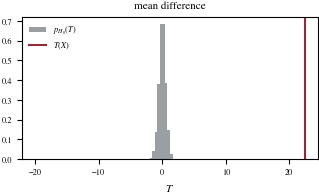

In [ ]:
fig, ax = plt.subplots()

bins = np.linspace(-20, 20, 101)
ax.set_title('mean difference')
ax.hist(mean_dist, bins=bins, density=True, label='$p_{H_0}(T)$', alpha=0.5, color=rgb.tue_dark)
ax.axvline(mean_true, label='$T(X)$', alpha=1.0, color=rgb.tue_red)
ax.legend(loc='upper left', frameon=False)
#ax.yaxis.set_visible(False)
ax.set_xlabel('$T$')

plt.show()

In [ ]:
bins = np.linspace(-40, 40, 101)
loc_data = np.argmax(bins >= mean_true)
histogram,_ = np.histogram(mean_dist, bins=bins, density=True)
empirical_cdf = np.cumsum(histogram) / np.sum(histogram)

p_value = empirical_cdf[loc_data]
print(p_value)

1.0000000000000002


In [ ]:
Y = np.concatenate([data_weekend["Minutes of delay"].values, data_weekday["Minutes of delay"].values]) # all race times, shape = (1, N)
rng = np.random.default_rng(1) # random number generator
B = 100000 # number of permuations to produce

Text(0.5, 0, '$T$')

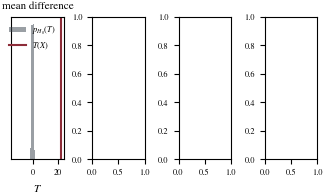

In [ ]:
fig, axs = plt.subplots(1,4)

ax = axs[0]
bins = np.linspace(-15, 15, 31)
ax.set_title('mean difference')
ax.hist(mean_dist, bins=bins, density=True, label='$p_{H_0}(T)$', alpha=0.5, color=rgb.tue_dark)
ax.axvline(mean_true, label='$T(X)$', alpha=1.0, color=rgb.tue_red)
ax.legend(loc='upper right', frameon=False)
ax.yaxis.set_visible(False)
ax.set_xlabel('$T$')